<a href="https://colab.research.google.com/github/horsinnaround/Breast-Image-Classification/blob/main/work_10_image_breast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
{"username":"willyvonka","key":"3d1cb64146d78ae03381d71488bba934"}

{'username': 'willyvonka', 'key': '3d1cb64146d78ae03381d71488bba934'}

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/forderation/breakhis-400x/download?datasetVersionNumber=1')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: willyvonka
Your Kaggle Key: ··········


100%|██████████| 803M/803M [00:23<00:00, 35.5MB/s]


# Kaggle

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import os
for dirname, _, filenames in os.walk('/content/breakhis-400x'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-17614-400-026.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-9461-400-025.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-20629-400-001.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-12312-400-034.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-2523-400-027.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_PC-14-19440-400-018.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-5694-400-022.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-16716-400-011.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-4372-400-017.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-14926-400-013.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-5287-400-020.png
/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_MC-14-16456-400-011.png
/content/breakhis-400

In [ ]:
import torch
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler, Adam
import copy
import json
import os
from os.path import exists
from albumentations import (
    Compose, OneOf, Normalize, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, Rotate, ShiftScaleRotate, Cutout, 
    HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2
# check if CUDA is available
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
def get_transforms(data):
    
    if data == 'train':
        
        return Compose([
            #Resize(CFG.size, CFG.size),
            RandomResizedCrop(512, 512, scale=(0.85, 1.0)),
            HorizontalFlip(p=0.25),
            VerticalFlip(p=0.25),
            CoarseDropout(p=0.2),
            Cutout(p=0.2, max_h_size=16, max_w_size=16, fill_value=(0., 0., 0.), num_holes=16),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
            
        ])

    elif data == 'valid':
        
        return Compose([
            Resize(512, 512),
            
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
            
        ])
    
class ImageDataset(Dataset):
    
    def __init__(self, train=True):
        
        if train:
            self.benign_files = os.listdir("/content/breakhis-400x/BreaKHis 400X/train/benign")
            self.malignant_files = os.listdir("/content/breakhis-400x/BreaKHis 400X/train/malignant")
        else:
            self.benign_files = os.listdir("/content/breakhis-400x/BreaKHis 400X/test/benign")
            self.malignant_files = os.listdir("/content/breakhis-400x/BreaKHis 400X/test/malignant")
            
        self.full_files = (self.malignant_files) + (self.benign_files)
        #print(self.full_files[1100:])
        #print(len(self.malignant_files))
        self.train = 'train' if train == True else 'valid'
        self.transforms = get_transforms(self.train)
        
    def __getitem__(self, idx):
        
        filename = self.full_files[idx]
        #print(filename)
        if self.train == 'train':
            
            if filename.startswith("SOB_B"):

                label = np.array(0)
                image = Image.open(os.path.join("/content/breakhis-400x/BreaKHis 400X/train/benign", filename))

            else:

                label = np.array(1)
                image = Image.open(os.path.join("/content/breakhis-400x/BreaKHis 400X/train/malignant", filename))
        else:
            
            if filename.startswith("SOB_B"):

                label = np.array(0)
                image = Image.open(os.path.join("/content/breakhis-400x/BreaKHis 400X/test/benign", filename))

            else:

                label = np.array(1)
                image = Image.open(os.path.join("/content/breakhis-400x/BreaKHis 400X/test/malignant", filename))
            
        image = self.transforms(image=np.array(image, dtype=np.float32))

        label = torch.tensor(label).long()
        
        return (image['image'], label)
        
    def __len__(self):
        
        return len(self.full_files)

In [ ]:
image_datasets = {
    'train': 
    ImageDataset(train=True),
    
    'valid': 
    ImageDataset(train=False)
}


dataloaders = {
    'train':
    DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,
                                num_workers=0),
    'valid':
    DataLoader(image_datasets['valid'],
                                batch_size=64,
                                shuffle=False,
                                num_workers=0)
}
dataset_sizes={'train': [], 'valid': []}
dataset_sizes['train']=len(image_datasets['train'])
dataset_sizes['valid']=len(image_datasets['valid'])

/usr/local/lib/python3.7/dist-packages/albumentations/augmentations/dropout/cutout.py:52: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  FutureWarning,


In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 64),
               nn.ReLU(inplace=True),
               nn.Linear(64, 32),
               nn.ReLU(inplace=True),
               nn.Linear(32, 2)).to(device)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = Model().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.02,momentum=0.9)
criterion = torch.nn.CrossEntropyLoss(reduction='mean')
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 100, eta_min=1e-8)



summary(model, input_size=(3, 224, 224))

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc_v = 0.0
    best_acc_T = 0.0
    best_loss_v= 1.0
    best_loss_T= 1.0
    loss_dict = {'train': [], 'valid': []}
    acc_dict = {'train': [], 'valid': []}
    epochs_list=[]

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        epochs_list.append(epoch)
        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
              

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward() 
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Add Metrics here there are the shit
            
            if phase == 'train':
                scheduler.step()
                #print(labels)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            loss_dict[phase].append(epoch_loss)
            acc_dict[phase].append(epoch_acc)
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc_v))
    print('Best train  accuracy: {:4f}'.format(best_acc_T))
    print('valid losss: {:4f}'.format(best_loss_v))
    print('train losss: {:4f}'.format(best_loss_T))



    model.load_state_dict(best_model_wts)       

    return model,loss_dict, acc_dict,epochs_list, time_elapsed

In [ ]:
model_ft,loss_dict, acc_dict,epoch_list,time_elapsed = train_model(model, criterion, optimizer,scheduler, num_epochs=100)

In [ ]:
time_elapse=0
time_elapse=time_elapse+time_elapsed
print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapse // 60, time_elapse % 60))

Training complete in 103m 37s


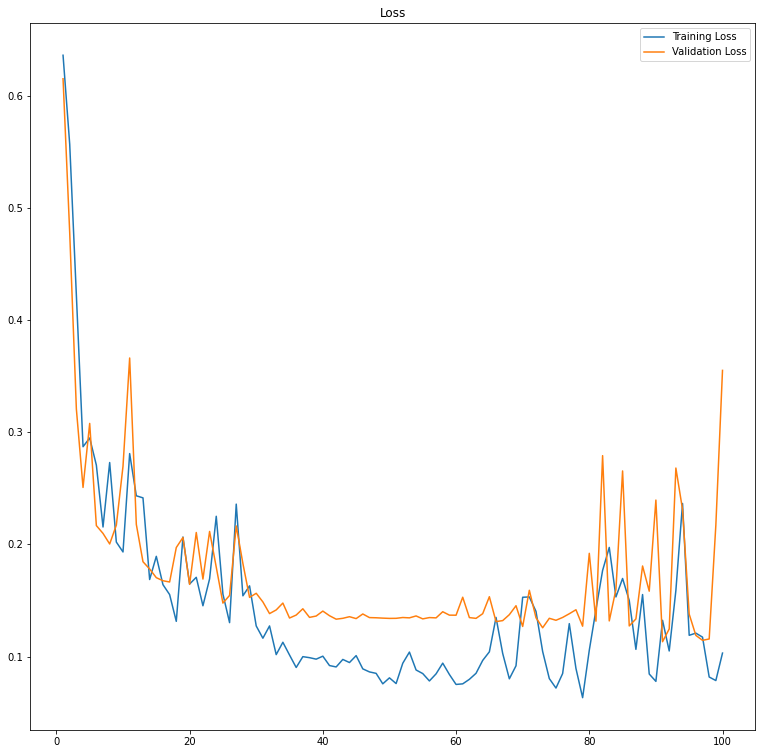

In [ ]:
from torch.utils.data import DataLoader
plt.rcParams["figure.figsize"] = (13,13)

plt.title("Loss")

plt.plot(epoch_list,loss_dict['train'],label='Training Loss')  
plt.plot(epoch_list,loss_dict['valid'],label='Validation Loss')  

plt.legend()  
plt.show()

In [ ]:
acc_dict

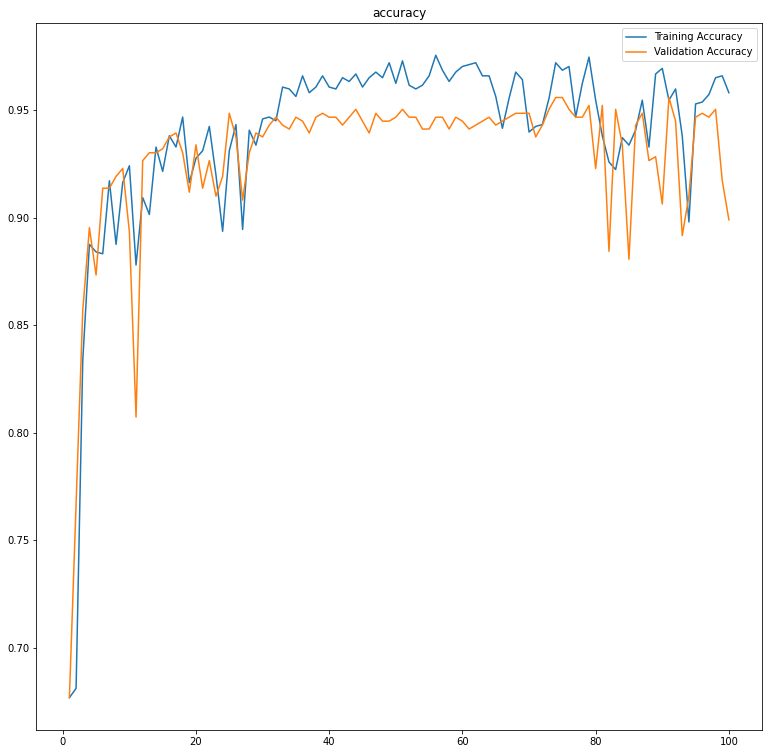

In [ ]:
acc_dict['valid'] = [x.cpu().numpy() for x in acc_dict['valid']]
acc_dict['train'] = [x.cpu().numpy() for x in acc_dict['train']]

plt.rcParams["figure.figsize"] = (13,13)

plt.title("accuracy")

plt.plot(epoch_list,acc_dict['train'],label='Training Accuracy')  
plt.plot(epoch_list,acc_dict['valid'],label='Validation Accuracy')  

plt.legend()  
plt.show()  

In [ ]:
np.mean(acc_dict['valid'])

NameError: ignored

# Tensor Flow

In [ ]:
import os
import gc
import cv2
import json
import math
import scipy
import itertools
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from tensorflow.keras.applications import ResNet50,MobileNet, DenseNet201, InceptionV3, NASNetLarge, InceptionResNetV2, NASNetMobile
from keras import layers
# from keras.applications.resnet50 import ResNet50
from keras.applications import resnet
from keras.layers import Dense,Dropout,Activation,Add,MaxPooling2D,Conv2D,Flatten,BatchNormalization
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
# from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
from tqdm import tqdm
from keras import backend as K
from functools import partial
from collections import Counter

%matplotlib inline

In [ ]:
import tensorflow as tf
import tensorflow

In [ ]:
dir(tensorflow.keras.applications)

In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)

BATCH_SIZE = 12

def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('/content/breakhis-400x/BreaKHis 400X/train/benign',224))
malign_train = np.array(Dataset_loader('/content/breakhis-400x/BreaKHis 400X/train/malignant',224))
benign_test = np.array(Dataset_loader('/content/breakhis-400x/BreaKHis 400X/test/benign',224))
malign_test = np.array(Dataset_loader('/content/breakhis-400x/BreaKHis 400X/test/malignant',224))

100%|██████████| 369/369 [00:05<00:00, 66.53it/s]


In [ ]:
BATCH_SIZE = 8

In [ ]:
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))
label =  {0:"benign",1:"malignant"}

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# Shuffle train data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
Y_train = Y_train[s]

# Shuffle test data
s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

# To categorical
Y_train = to_categorical(Y_train, num_classes= 2)
Y_test = to_categorical(Y_test, num_classes= 2)

x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, 
    test_size=0.2, 
    random_state=11
)

In [ ]:
#build cnn
def build_model(backbone, lr=1e-4):
    model = Sequential()
    # model.build(input_shape=(224,224,3))

    model.add(backbone)
    model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(320, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    # model.add(Conv2D(128, (3, 3), padding="valid", activation="relu"))
    # model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    # model.add(Conv2D(256, (3, 3), padding="valid", activation="relu"))
    # model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
    model.add(Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

K.clear_session()
gc.collect()

# resnet = NASNetLarge(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(331,331,3)
# )
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256,3)
)

model = build_model(resnet ,lr = 1e-4)
model.summary()

74850304/74836368 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 16)          276496    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 320)         46400     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 320)        0         
 2D)                                                             
                                                         

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
#early stop  to avoid overfitting
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [ ]:
tensorboard_callback

In [ ]:
history = model.fit(
    # train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    # steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    train,
    epochs=20,
    validation_data=val,
    callbacks=[early_stop]
)

In [ ]:
#evaluate model
model.evaluate(val)

7/7 [==============================] - 10s 186ms/step - loss: 0.0207 - accuracy: 0.9955


[0.02070477232336998, 0.9955357313156128]

In [ ]:
history.history['val_accuracy'][:20]

[0.7053571343421936,
 0.7053571343421936,
 0.7232142686843872,
 0.7053571343421936,
 0.7901785969734192,
 0.75,
 0.8080357313156128,
 0.8705357313156128,
 0.8526785969734192,
 0.9241071343421936,
 0.9196428656578064,
 0.9375,
 0.9732142686843872,
 0.96875,
 0.9910714030265808,
 0.9776785969734192,
 0.9955357313156128,
 0.9910714030265808,
 1.0,
 1.0]

In [ ]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy'][:20]
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16,12),dpi=600)
#accuracy plot
plt.plot(epochs, accuracy, color='b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, color='r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('/content/drive/MyDrive/A work breast image/training validation accuracy.jpg',bbox_inches='tight')
plt.show()

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


In [ ]:
len(history.history['val_accuracy'])

40

In [ ]:
epcs = pd.DataFrame()
epcs['Epoch'] = [i for i in range(1,21) ]
epcs['accuracy'] = history.history['accuracy']
epcs['val_accuracy'] = history.history['val_accuracy']
# epcs['loss'] = history.history['loss']
# epcs['val_loss'] = history.history['val_loss']


In [ ]:
epcs = pd.DataFrame()
epcs['Epoch'] = l2
epcs['accuracy'] = acc2
epcs['title'] = name2
# epcs['loss'] = history.history['loss']
# epcs['val_loss'] = history.history['val_loss']


In [ ]:
epcs

,Epoch,accuracy,title
0,1,0.705357,validation accuracy
1,2,0.705357,validation accuracy
2,3,0.723214,validation accuracy
3,4,0.705357,validation accuracy
4,5,0.790179,validation accuracy
5,6,0.750000,validation accuracy
6,7,0.808036,validation accuracy
7,8,0.870536,validation accuracy
8,9,0.852679,validation accuracy
9,10,0.924107,validation accuracy


In [ ]:
l = [i for i in range(1,21) ]

In [ ]:
# l2 = []
for i in l:
    l2.append(i)
len(l2)

40

In [ ]:
name

In [ ]:
# acc2 = []
# name2 = []
for i in accuracy:
    acc2.append(i)
    name2.append('train accuracy')
len(acc2)

40

In [ ]:
epcs

,Epoch,accuracy,val_accuracy,loss,val_loss
0,1,0.606027,0.705357,0.708479,0.668866
1,2,0.766741,0.705357,0.487464,0.622905
2,3,0.867188,0.723214,0.324825,0.688383
3,4,0.921875,0.705357,0.246469,0.609985
4,5,0.931920,0.790179,0.195928,0.439605
5,6,0.972098,0.750000,0.133305,0.505725
6,7,0.981027,0.808036,0.104362,0.395014
7,8,0.993304,0.870536,0.072753,0.295869
8,9,0.995536,0.852679,0.061717,0.299320
9,10,0.992188,0.924107,0.066526,0.186975


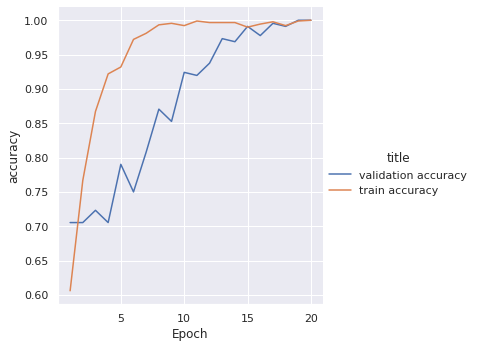

In [ ]:
sns.relplot(
    data=epcs, kind="line",
    x="Epoch", y="accuracy",hue='title'
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


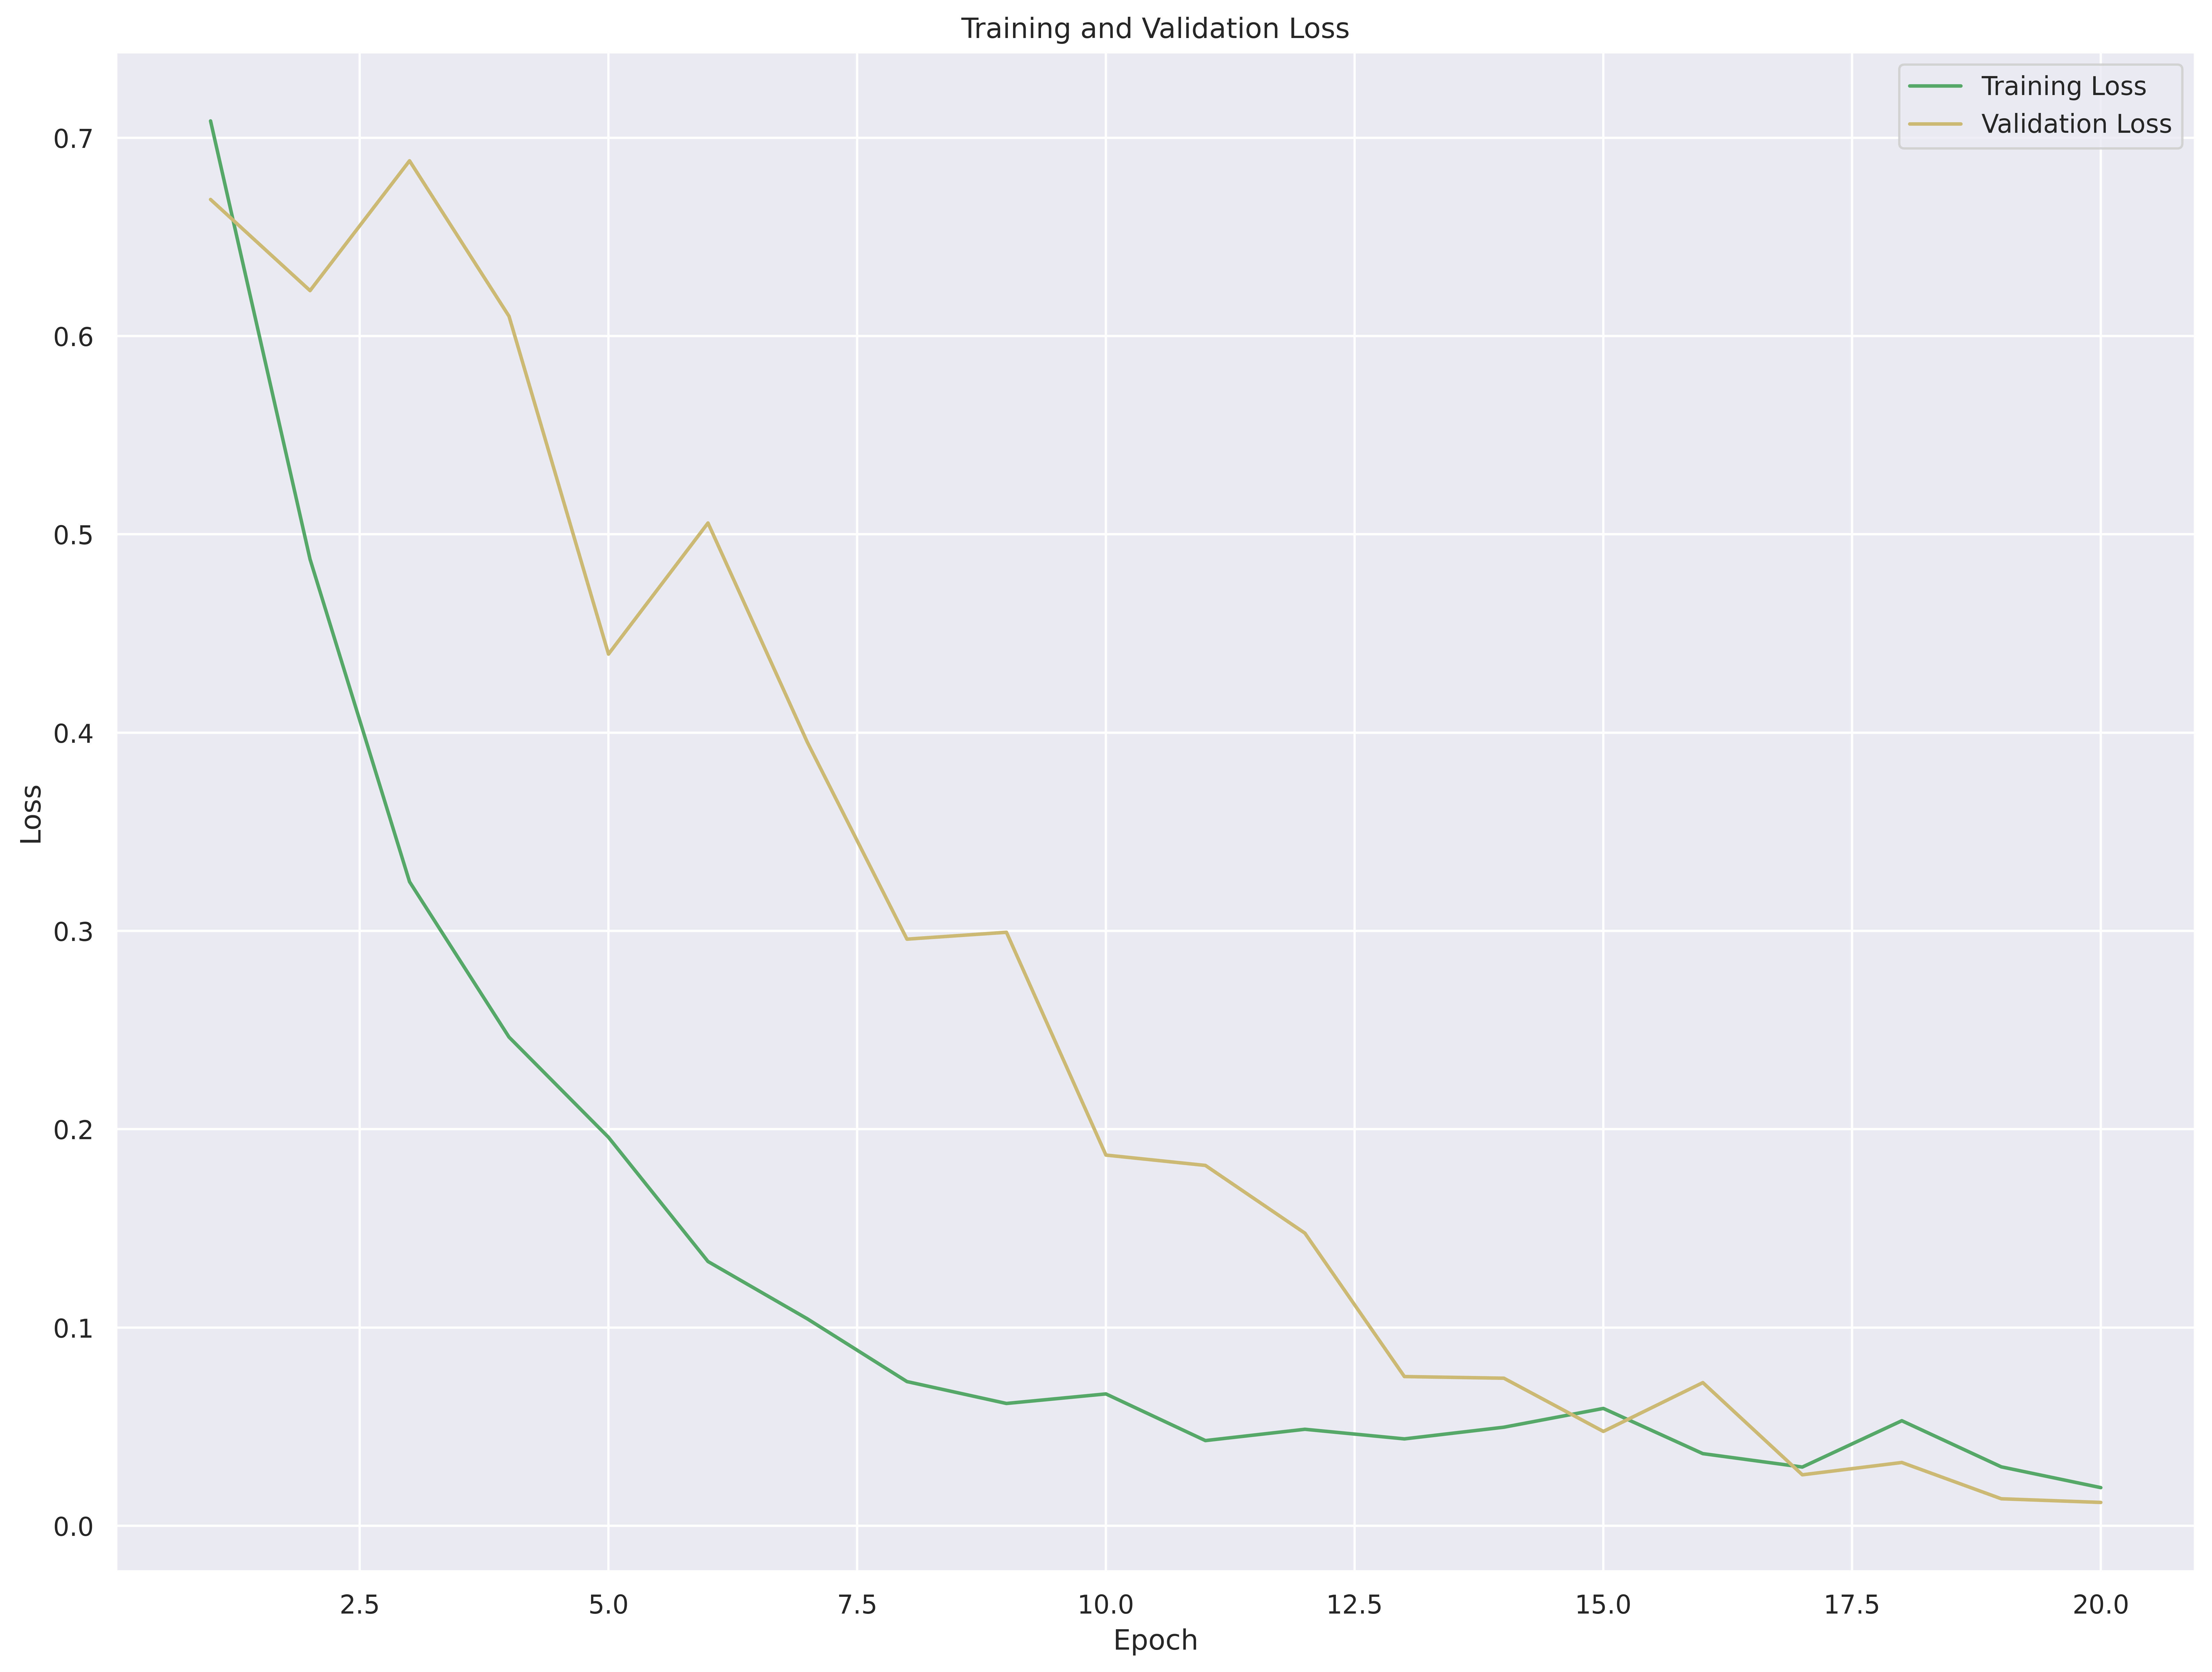

In [ ]:
plt.figure(figsize=(16,12),dpi=600)

#loss plot
plt.plot(epochs, loss, color='g', label='Training Loss')
plt.plot(epochs, val_loss, color='y', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/A work breast image/training validation loss.jpg',bbox_inches='tight')

plt.show()

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy, AUC
pre = Precision()
re = Recall()
bi = BinaryAccuracy()
# ac = Accuracy()
au = AUC()

In [ ]:
Y,Yhat = [],[]
for batch in val.as_numpy_iterator():
    X,y = batch
    yhat = model.predict(X)
    for i in y:
        Y.append(float(i))
    for j in yhat:
        Yhat.append(float(j))
    pre.update_state(y,yhat)
    re.update_state(y,yhat)
    bi.update_state(y,yhat)
    # ac.update_state(y,yhat)
    au.update_state(y,yhat)

In [ ]:
k = pd.DataFrame()
k['real'] = Y
k["pred"] = Yhat

In [ ]:
k[10:20]

,real,pred
10,1.0,0.983683
11,1.0,0.999137
12,1.0,0.986303
13,1.0,0.994064
14,0.0,0.000473
15,1.0,0.989202
16,1.0,0.992887
17,1.0,0.975733
18,0.0,0.000115
19,1.0,0.988408


In [ ]:
# float(np.array(au.result()))
# pre.result(),re.result(),bi.result(),au.result()

In [ ]:
Yhat

In [ ]:
pres = float(np.array(pre.result()))
recs = float(np.array(re.result()))
bis = float(np.array(bi.result()))
f1sc = (2 * float(np.array(pre.result()))*float(np.array(re.result())))/(float(np.array(pre.result()))+float(np.array(re.result())))
aucs = float(np.array(au.result()))

In [ ]:
print("Precision: {}\nRecall: {}\nF1 Score: {}\nAccuracy: {}\nAUC: {}".format(pres,recs,f1sc,bis,aucs))

Precision: 0.9937888383865356
Recall: 1.0
F1 Score: 0.9968847445156275
Accuracy: 0.9955357313156128
AUC: 1.0


In [ ]:
result = pd.DataFrame()
result["Name"] = ["densenet201","densenet201"]
result['Accuracy'] = [bis,bis]
result['Precision'] = [pres,pres]
result['Recall'] = [recs,recs]
result['F1 Score'] = [f1sc,f1sc]
result['AUC'] = [aucs,aucs]


In [ ]:
result.drop(1,inplace=True)

In [ ]:
met.to_csv('/content/drive/MyDrive/A work breast image/met.csv',index=False)
met

,name,value,metric
0,densenet201,0.995536,Accuracy
1,densenet201,0.993789,Precision
2,densenet201,1.000000,Recall
3,densenet201,0.996885,F1 Score
4,densenet201,1.000000,AUC


In [ ]:
met = pd.DataFrame()
met['name'] = ['densenet201','densenet201','densenet201','densenet201','densenet201']
met['value'] = [0.995536 	,0.993789 	,0.996442 	,0.996885 	,0.994451]
met['metric'] = ['Accuracy','Precision','Recall','F1 Score','AUC']

In [ ]:
met

,name,value,metric
0,densenet201,0.995536,Accuracy
1,densenet201,0.993789,Precision
2,densenet201,0.996442,Recall
3,densenet201,0.996885,F1 Score
4,densenet201,0.994451,AUC


In [ ]:
# di = pd.read_csv('./result.csv')
# di

FileNotFoundError: ignored

In [ ]:
met.index = ['densenet201','densenet201','densenet201','densenet201','densenet201']

In [ ]:
met.drop('name',inplace=True,axis=1)

In [ ]:
der = pd.read_csv('/content/analys(3) - Copy.csv')

In [ ]:
der

,model name,accuracy,weighted precision,weighted recall,weighted f1_score,auc
0,ExtraTreesClassifier,0.872820,0.872480,0.872820,0.870300,0.838720
1,RandomForestClassifier,0.861500,0.860780,0.861500,0.858620,0.824600
2,KNeighborsClassifier,0.860640,0.860380,0.860640,0.858800,0.831660
3,DecisionTreeClassifier,0.828400,0.831180,0.828400,0.828720,0.806280
4,SVC,0.861500,0.862060,0.861500,0.856820,0.816200
5,XGBClassifier,0.859720,0.859400,0.859720,0.856360,0.822320
6,densenet201,0.995536,0.993789,0.996442,0.996885,0.994451


In [ ]:
der.drop('model name',axis=1,inplace=True)

In [ ]:
der.columns = ['accuracy', 'precision', 'recall','f1_score', 'auc']

In [ ]:
der.index = der['model name']

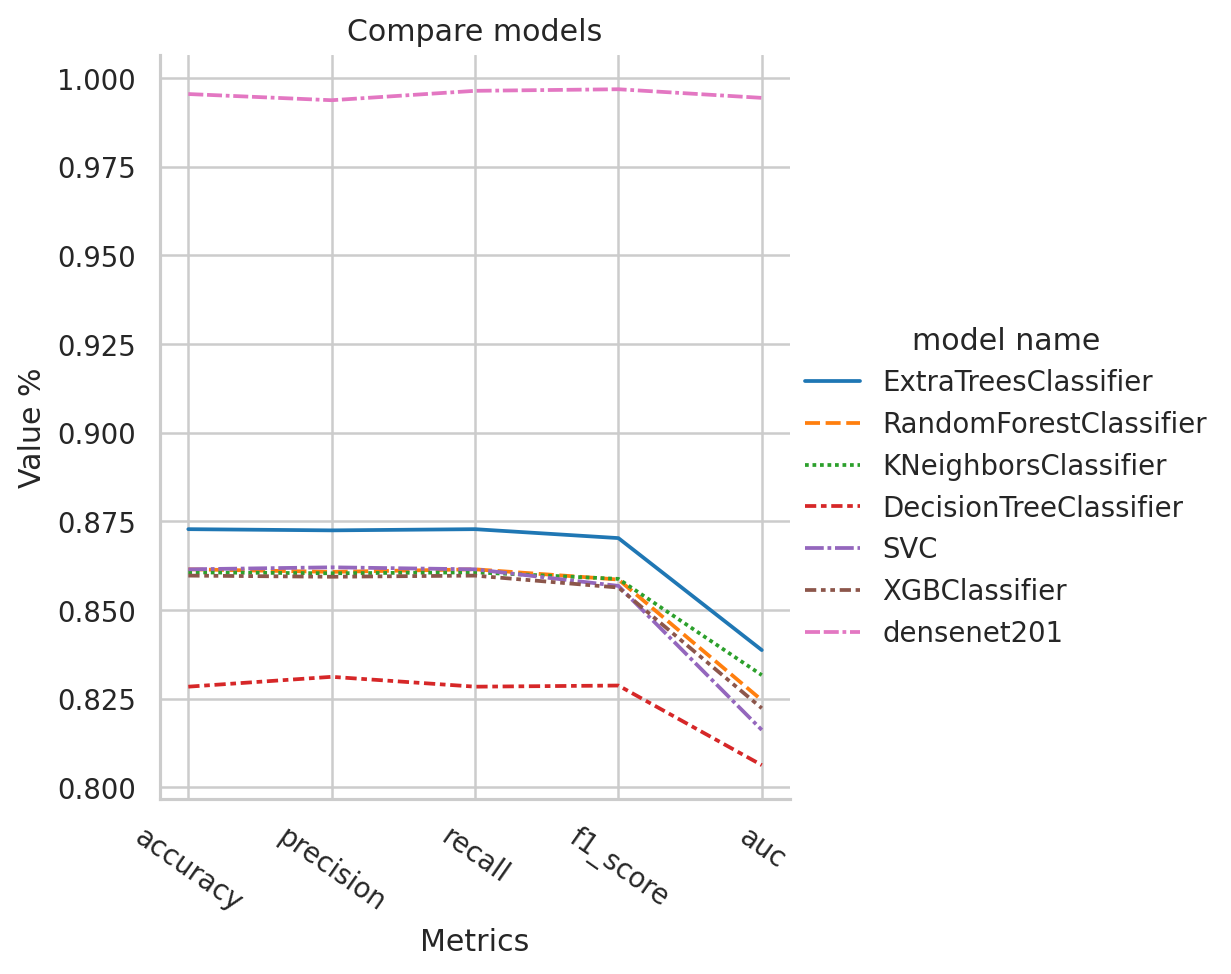

In [ ]:
sns.relplot(data=der.T,kind='line')
plt.xticks(rotation=-35)
plt.title('Compare models')
plt.xlabel("Metrics")
plt.ylabel("Value %")
plt.savefig('/content/compare p metrics.jpg',bbox_inches='tight')

In [ ]:
der['model name'] = der.index

In [ ]:
der.to_csv('/content/compare p metrics.csv',index=False)

AttributeError: ignored

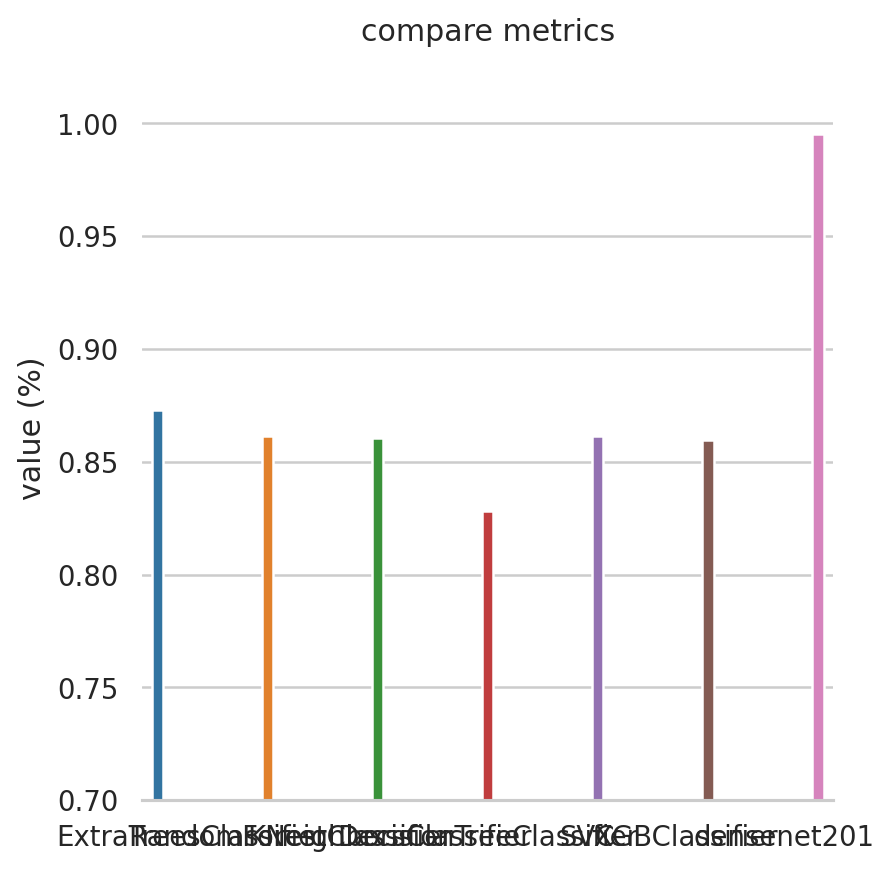

In [ ]:
import seaborn as sns
sns.set_theme(style="white")
sns.set(rc={"figure.dpi":180, 'savefig.dpi':600})
# penguins = sns.load_dataset("penguins")
# sns.set_theme(style="whitegrid")
sns.set_style('whitegrid')
sns.set_palette('tab10')
# Draw a nested barplot by species and sex
g = sns.catplot(
    data=der, kind="bar",
    x="model name",
    y="accuracy",
    hue="model name",
)
plt.ylim(0.7,1.03)
plt.title('compare models')
g.despine(left=True)
g.set_axis_labels("", "value (%)")
g.legend.set_title("metrics")
plt.savefig('/content/compare p metrics.jpg',bbox_inches='tight')


In [ ]:
Y_pred = model.predict(val)
Y_pred = np.argmax(Y_pred,axis=1)
Y_pred

In [ ]:
y = Y_test.T[1]
y2 = Y_pred

In [ ]:
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score

In [ ]:
yhat

array([[9.8431498e-01],
       [4.6553803e-04],
       [9.9649042e-01],
       [9.9929893e-01],
       [9.8222625e-01],
       [9.9161303e-01],
       [3.8674045e-02],
       [9.8092318e-01],
       [4.1699427e-04],
       [9.9386674e-01],
       [9.9011725e-01],
       [9.7862816e-01],
       [9.7252309e-01],
       [5.5653113e-04],
       [1.7526363e-04],
       [8.3532892e-03],
       [9.9093610e-01],
       [9.8939896e-01],
       [1.2149692e-04],
       [6.5115868e-04],
       [9.8786700e-01],
       [1.5482994e-03],
       [9.9610943e-01],
       [9.8198539e-01],
       [9.8035884e-01],
       [9.3526220e-01],
       [8.5172701e-01],
       [9.9066520e-01],
       [9.9406356e-01],
       [9.7169703e-01],
       [9.9261087e-01],
       [9.8920202e-01]], dtype=float32)

In [ ]:
print(classification_report(y,yhat))

In [ ]:


tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0)



100%|██████████| 10/10 [01:43<00:00, 10.34s/it]


In [ ]:
Y_pred_tta

array([[0.77385277, 0.19495969],
       [0.92200166, 0.06942368],
       [0.6983529 , 0.30320328],
       ...,
       [0.13433318, 0.87056714],
       [0.34405366, 0.65686953],
       [0.4360269 , 0.6029661 ]], dtype=float32)

In [ ]:
import cv2

In [ ]:
lin=[
"/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-5695-400-017.png",
"/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_MC-14-19979-400-019.png",
"/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_LC-14-15570-400-016.png",
"/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-16336-400-008.png",
"/content/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_PT-14-22704-400-009.png",
"/content/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_TA-14-16184-400-012.png",
"/content/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-025.png",
"/content/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_PT-14-21998AB-400-052.png"
]

In [ ]:
lin[1]

'/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_MC-14-19979-400-019.png'

In [ ]:
# fir = '/content/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-007.png'
# fir = "/content/breakhis-400x/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-022.png"
# fir = "/content/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-007.png"
fir = "/content/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png"
nm = 4

In [ ]:
# nm = 1

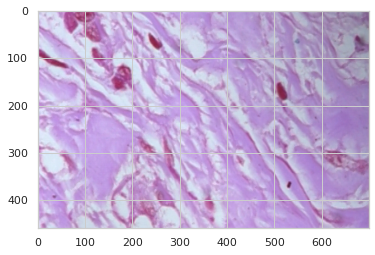

In [ ]:
# plt.figure(dpi=600)
nm = 201
img = cv2.imread('/content/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-13412-400-005.png')
plt.imshow(img)
plt.show()
# plt.savefig(f'/content/drive/MyDrive/A work breast image/imsge{nm}.jpg',bbox_inches='tight')



In [ ]:
resize = tf.image.resize(img, (256,256))
yh = model.predict(np.expand_dims(resize/255,0))
yh

array([[0.9679195]], dtype=float32)

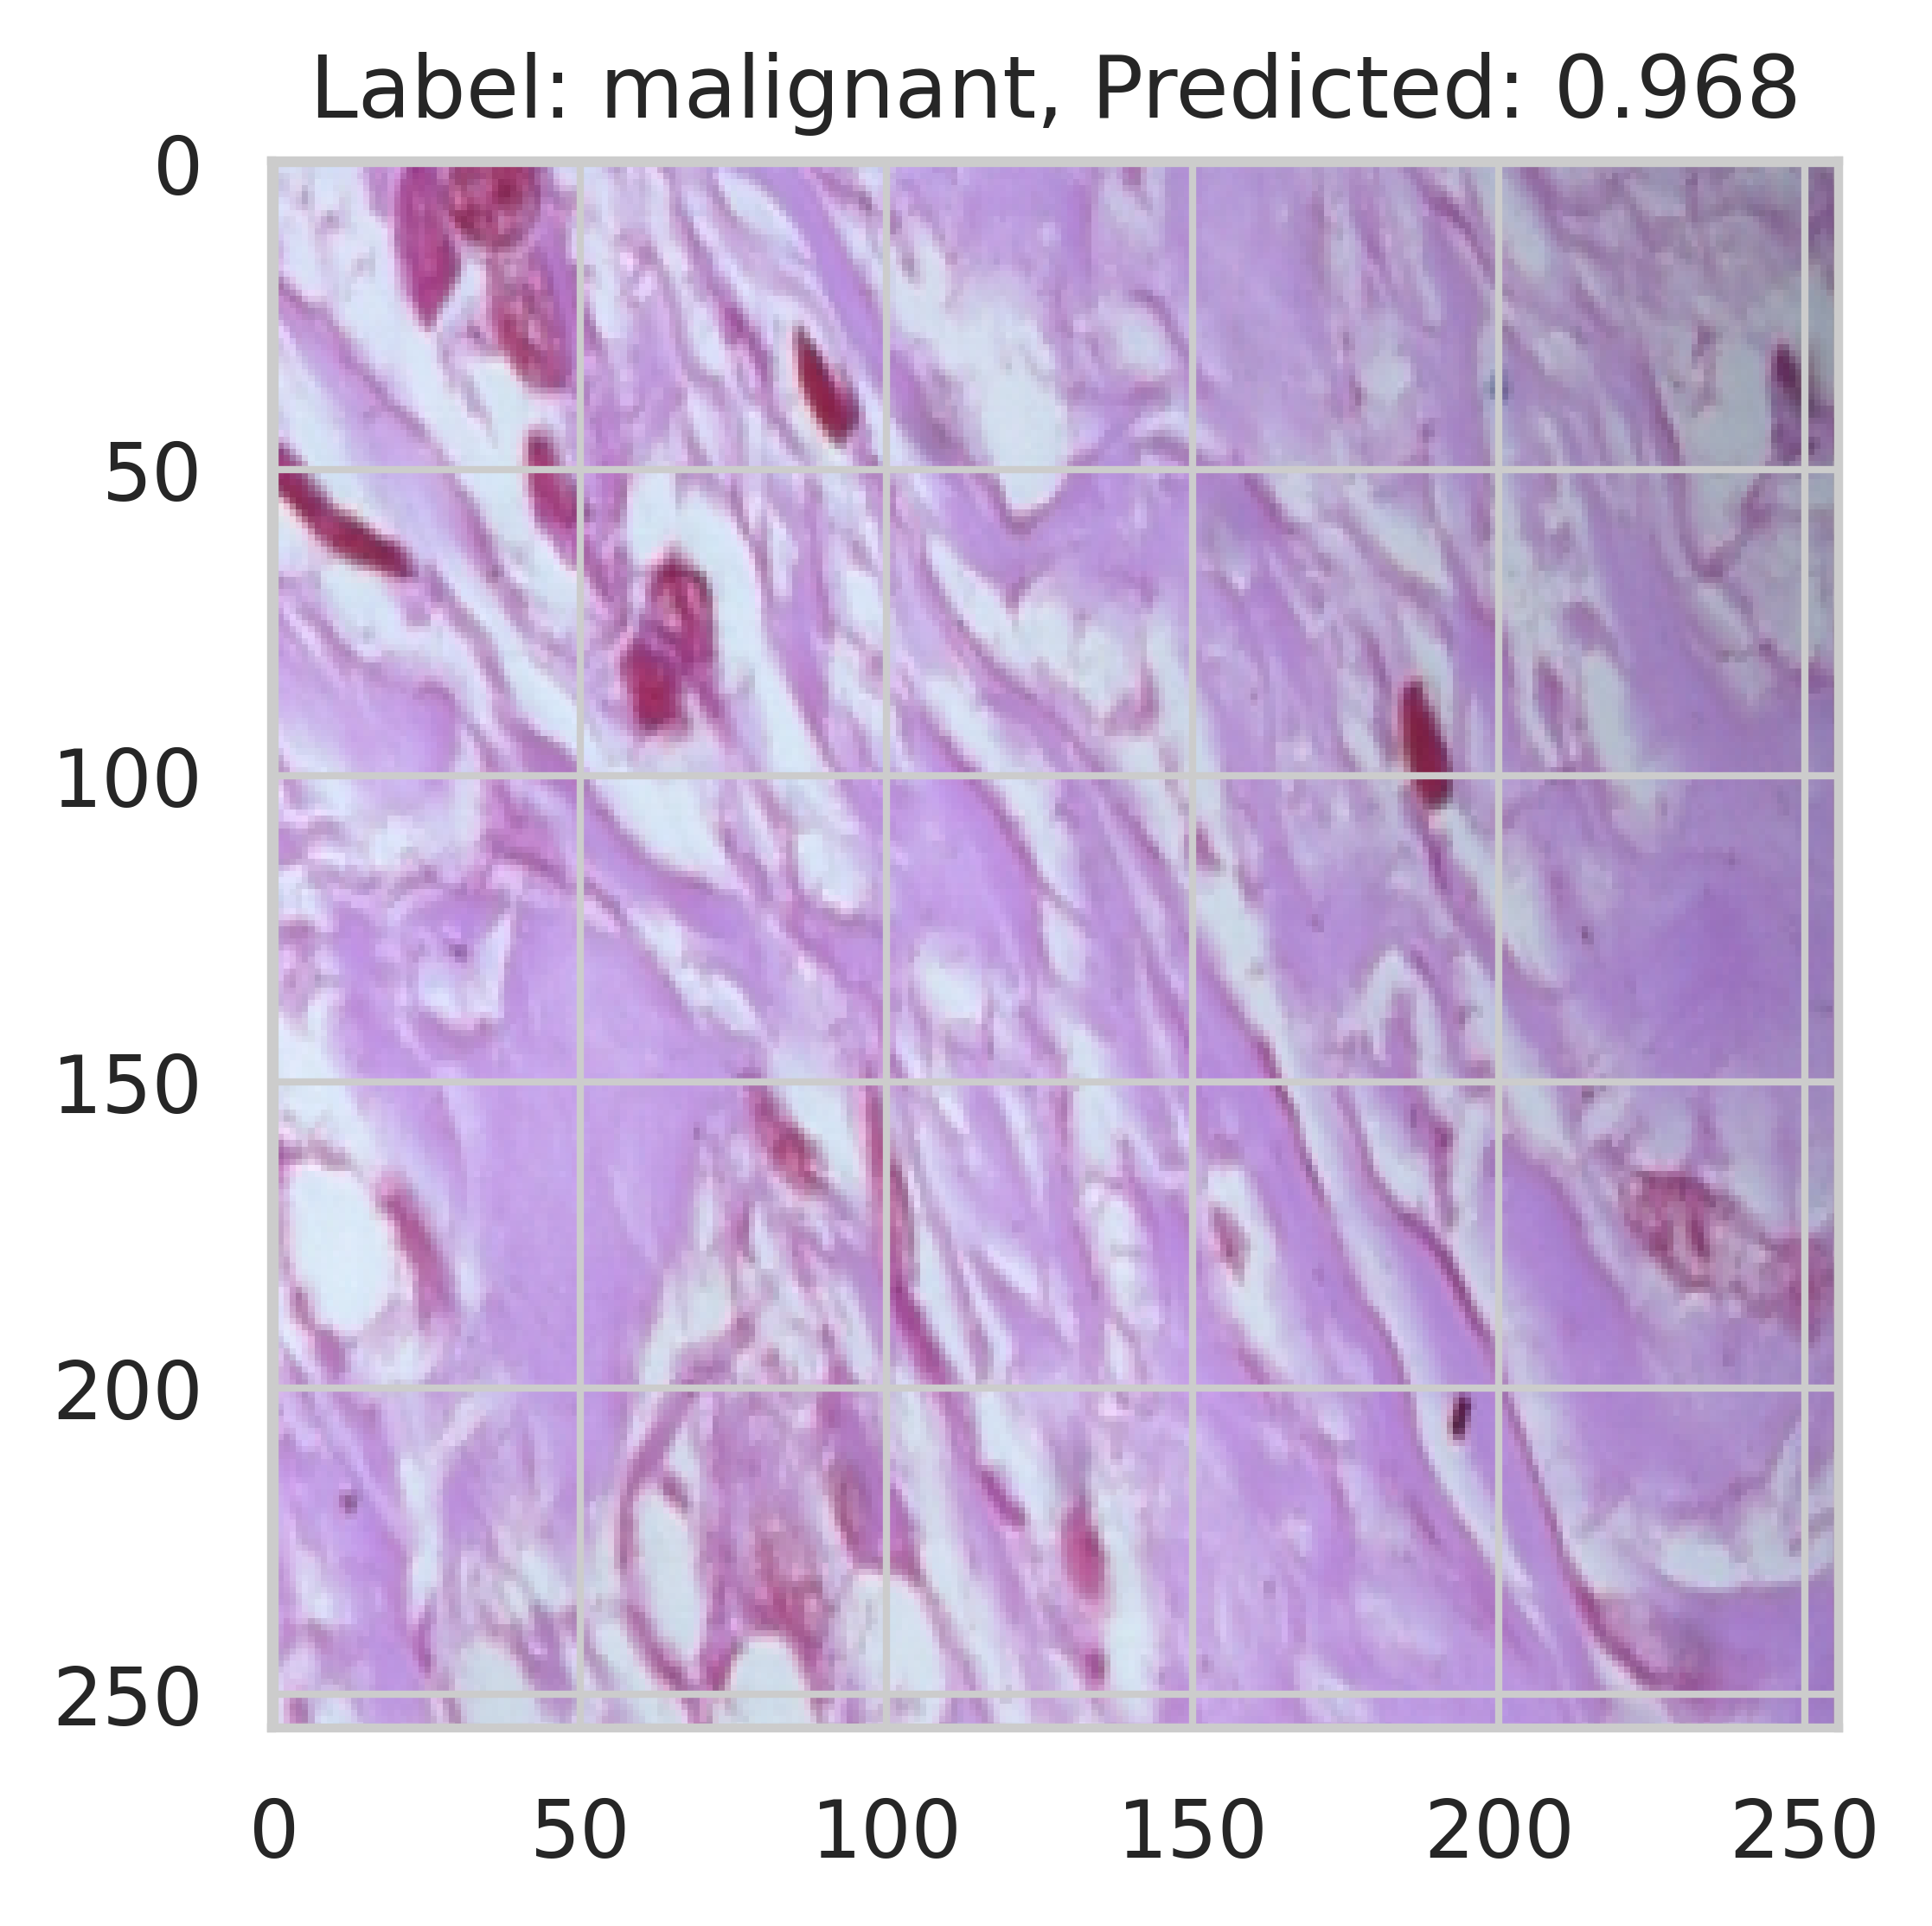

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.figure(dpi=600)
# resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
# malignant
# benign
plt.title("Label: {}, Predicted: {}".format("malignant",round(float(yh),3)))
plt.show()
plt.savefig(f'/content/drive/MyDrive/A work breast image/image{nm} resize.jpg',bbox_inches='tight')


In [ ]:
yh = model.predict(np.expand_dims(resize/255,0))

In [ ]:
float(yh)

0.975035548210144

In [ ]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy()astype(int))
plt.show()

#test model 1 
fir = '/content/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-007.png'
img_ = image.load_img(fir, target_size=(256,256))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
# print(pred)
# print(label[pred[0]])
plt.figure(figsize=(5,5),dpi=600)
plt.title("Predicted:{}".format(label[pred[0]]))
plt.imshow(img_)
plt.savefig('/content/drive/MyDrive/A work breast image/image 3.jpg',bbox_inches='tight')

# model.save('/kaggle/working/final_model.h5')



SyntaxError: ignored

[0]
benign


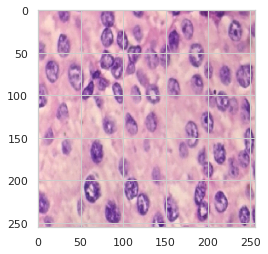

In [ ]:
#test model 4
img_ = image.load_img("/content/breakhis-400x/BreaKHis 400X/test/malignant/SOB_M_DC-14-11031-400-003.png", target_size=(256, 256))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:
label

{0: 'benign', 1: 'malignant'}

In [ ]:
#test model 5
img_ = image.load_img("/content/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-11031-400-007.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:
#test model 6
img_ = image.load_img("/content/breakhis-400x/BreaKHis 400X/train/benign/SOB_B_A-14-22549AB-400-022.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

In [ ]:


#test model 3
img_ = image.load_img("/content/breakhis-400x/BreaKHis 400X/train/malignant/SOB_M_DC-14-9461-400-006.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)



In [ ]:
#test model 2
img_ = image.load_img("/content/breakhis-400x/BreaKHis 400X/test/benign/SOB_B_A-14-22549AB-400-003.png", target_size=(244, 244))
imag = image.img_to_array(img_)
imag = np.expand_dims(imag, axis=0)
pred = model.predict(imag)
pred = np.argmax(pred,axis=1)
print(pred)
print(label[pred[0]])
plt.imshow(img_)

# Me Time

In [ ]:
import cv2
import imghdr
import os

In [ ]:
data_dir = "/content/breakhis-400x/BreaKHis 400X/train"
data_dirtest = "/content/breakhis-400x/BreaKHis 400X/test"

In [ ]:
img_exts = ['jpeg','jpg','bmp','png']

In [ ]:
l = 1
for image_class in os.listdir(data_dir):

    l=l+1
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir,image_class,image)

        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts:
                print("image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("issue with image {}".format(image_path))
print(l)

3


In [ ]:
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(160, 160))

Found 1148 files belonging to 2 classes.


Found 545 files belonging to 2 classes.


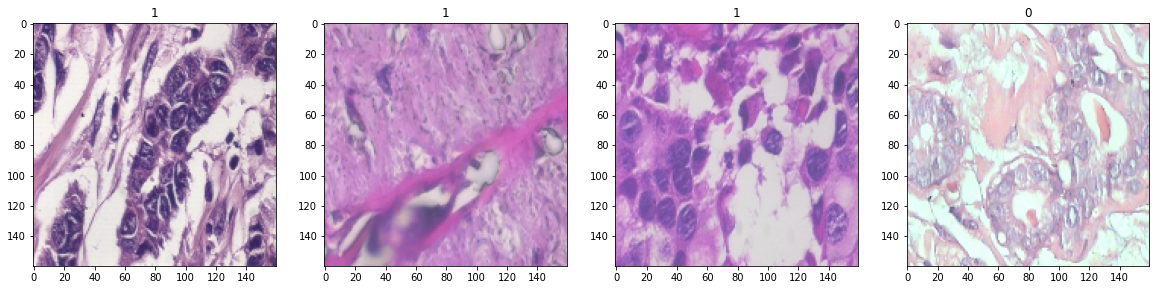

In [ ]:
datatest = tf.keras.utils.image_dataset_from_directory(data_dirtest,
                                                       class_names=['benign','malignant'],
                                                    #    shuffle=False,
                                                       image_size=(160, 160))
data_iteratortest = datatest.as_numpy_iterator()
batchtest = data_iteratortest.next()
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batchtest[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batchtest[1][idx])
datatest = datatest.map(lambda x,y: (x/255,y))


In [ ]:
tf.keras.utils.image_dataset_from_directory??

In [ ]:
len(data)

36

In [ ]:
data = tf.keras.utils.image_dataset_from_directory(data_dir,image_size=(160, 160))

Found 1148 files belonging to 2 classes.


In [ ]:
data_iterator = data.as_numpy_iterator()

In [ ]:
batch = data_iterator.next()

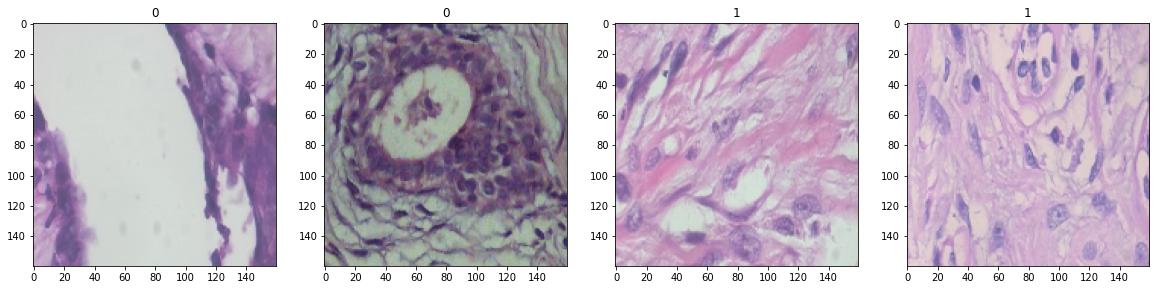

In [ ]:
fig, ax = plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
data = data.map(lambda x,y: (x/255,y))

In [ ]:
len(X[0])

In [ ]:
data.as_numpy_iterator().next()

In [ ]:
160*160 * 3

76800

In [ ]:
colname = [f"v{i}" for i in range(len(X[0]))]

In [ ]:
colname

In [ ]:
X_data = pd.DataFrame(X,columns=colname)

In [ ]:
X_data.to_csv('/content/drive/MyDrive/A DATA/data_to_array.csv',index=False)

In [ ]:
Y_data = pd.DataFrame()
Y_data['label'] = list(Y)
Y_data.to_csv('/content/drive/MyDrive/A DATA/label_to_array.csv',index=False)

In [ ]:
X_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1148 entries, 0 to 1147
Columns: 76800 entries, v0 to v76799
dtypes: float32(76800)
memory usage: 336.3 MB


In [ ]:
X,Y = [],[]
for batch in data.as_numpy_iterator():
    x,y = batch
    for i in range(len(y)):
        X.append(np.reshape(x[i],(1,-1)))
        Y.append(y[i])

In [ ]:
X[0]

array([206.11328, 107.46484, 158.94531, ..., 157.41797,  54.54297,
       119.56641], dtype=float32)

In [ ]:
for i in range(len(X)):
    X[i] = X[i][0]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor 
from sklearn.cluster import KMeans #one with clusterimg (disaster)
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor ,HistGradientBoostingClassifier,AdaBoostClassifier,ExtraTreesClassifier,StackingClassifier,VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression,Ridge,RidgeCV,Lasso,LassoLars,BayesianRidge,TweedieRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.dummy import DummyClassifier #that zero
# !pip install catboost
# from catboost import CatBoostClassifier 
from sklearn.gaussian_process.kernels import CompoundKernel,Matern,Hyperparameter,Exponentiation,ExpSineSquared,DotProduct,ConstantKernel
from sklearn.linear_model import PassiveAggressiveClassifier,Perceptron,RidgeClassifier,SGDClassifier
from sklearn.svm import SVC, SVR, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB,BernoulliNB,CategoricalNB,ComplementNB

from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import RadiusNeighborsClassifier

from sklearn import model_selection
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, cohen_kappa_score, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, jaccard_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import datasets, metrics
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

from sys import exit
import webbrowser
import time
import datetime
import threading
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
# from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np 
import pandas as pd 
import seaborn as sns
import itertools
import random as rn
from time import time
import warnings
import os
from IPython.display import clear_output

# Sampling
from imblearn.over_sampling import SVMSMOTE ,SMOTENC,ADASYN,KMeansSMOTE,BorderlineSMOTE,RandomOverSampler,SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import AllKNN,NearMiss,RandomUnderSampler

import sys

def str_to_class(classname):
    return getattr(sys.modules[__name__], classname)
clear_output()
print("WELLCOME TO IMPLEMENTATION")

WELLCOME TO IMPLEMENTATION


In [ ]:

CV = 5
k_fold = KFold(n_splits=CV,shuffle=True, random_state=random_state)
trts = list(k_fold.split(features, target))
from sklearn.metrics import cohen_kappa_score,zero_one_loss,matthews_corrcoef,jaccard_score,fbeta_score,hamming_loss #Compute Cohen’s kappa: a statistic that measures inter-annotator agreement.

In [ ]:
random_state = 0
model_list = [
    # VotingClassifier(estimators=[
    #     ('lr', KNeighborsClassifier()),
    #     ('rf', HistGradientBoostingClassifier(random_state= random_state)),
    #     ('gnb', GaussianProcessClassifier(random_state= random_state))],
    #     voting='soft'),
    HistGradientBoostingClassifier(random_state= random_state),
    # RadiusNeighborsClassifier(random_state= random_state),
    SGDClassifier(random_state= random_state),
    GaussianProcessClassifier(random_state= random_state),
    AdaBoostClassifier(random_state= random_state),
    ExtraTreesClassifier(random_state= random_state),
    RandomForestClassifier(random_state= random_state),
    LinearSVC(),
    KNeighborsClassifier(),
    # MultinomialNB(),
    DecisionTreeClassifier(random_state= random_state),
    # BernoulliNB(),
    NuSVC(),
    SVC(),
    MLPClassifier(random_state= random_state),
    XGBClassifier(random_state= random_state),
    CatBoostClassifier(verbose=0,random_state= random_state),
    LogisticRegression(random_state= random_state),
]

In [ ]:
features = pd.DataFrame(X_,columns=['d1','d2','d3','d4'])

In [ ]:
target=pd.DataFrame(Y,columns=['Target'])

In [ ]:
def sampling_NO_PLT(data,target,sample,random_state):
    print(len(target))
    print(random_state)
    try:
        sm = str_to_class(sample)(sampling_strategy='auto', 
                    random_state=random_state)
    except:
        sm = str_to_class(sample)(sampling_strategy='auto')
    print(sample)
    data_,labels_ = sm.fit_resample(data,target)
    print(len(labels_))
    return data_,labels_
    

In [ ]:
features,target = sampling_NO_PLT(features,target,sample='SMOTEENN',random_state=random_state)

1148
0
SMOTEENN
1186


In [ ]:
features['label'] = target

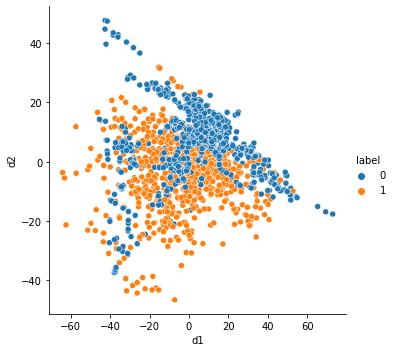

In [ ]:
sns.relplot(data=features,x='d1',y='d2',hue='label')

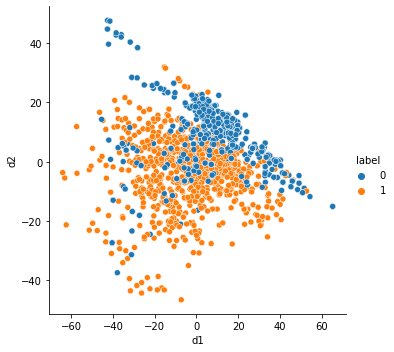

In [ ]:
sns.relplot(data=features,x='d1',y='d2',hue='label')

In [ ]:
features.drop('label',axis=1,inplace=True)

In [ ]:
features.describe().T

,count,mean,std,min,25%,50%,75%,max
d1,1554.0,0.144912,20.452302,-64.000195,-12.663252,0.838166,13.026601,72.810926
d2,1554.0,0.825827,12.495279,-46.539754,-5.934418,1.167246,8.743485,47.677934
d3,1554.0,0.286417,6.563685,-33.456546,-3.590120,-0.330309,3.072889,36.633626
d4,1554.0,0.149093,5.522974,-17.024228,-3.206408,0.125421,3.364383,28.337090


In [ ]:
from sklearn.metrics import auc,roc_curve,roc_auc_score

In [ ]:
%%time
n_avg = 5 # Number of times to average over
duration_fit_list=[]
duration_pred_list=[]
accuracy_score_list=[]
weighted_precision_score_list=[]
weighted_recall_score_list=[]
weighted_f1_score_list=[]
dcg_score_list = []
dcg_score_list2 = []
dcg_score_list3 = []
dcg_score_list4 = []

dcg_score_list5 = []


entries = []
fold = []
model_list_name = []
wh = "weighted" # ‘micro’, ‘macro’, ‘samples’, ‘weighted’, ‘binary’
for model in model_list:   # For different number of samples, we try training our estimator
    print(f"for {model} strated.")
    clf = model
    duration_fit=0
    duration_pred=0
    accuracy_scores = 0
    weighted_precision_scores = 0
    weighted_recall_scores = 0
    weighted_f1_scores = 0
    dcg_scores = 0
    dcg_scores2 = 0
    dcg_scores3 = 0
    dcg_scores4 = 0
    dcg_scores5 = 0


    j = 1
    e_in = 0
    e_out = 0   # For each, we record the in and out score. 
    for train_indices, test_indices in k_fold.split(features, target ):
        fold.append(j)
        j +=1
        
        X_train, y_train, X_test, y_test  = features.iloc[train_indices],target.iloc[train_indices],features.iloc[test_indices],target.iloc[test_indices]
        # X_train, y_train, X_test, y_test  = features[train_indices],target.iloc[train_indices],features[test_indices],target.iloc[test_indices]
        y_train, y_test = np.array(y_train), np.array(y_test)
        start_fit = time()
        clf.fit(X = X_train, y = y_train)
        end_fit = time()
        duration_fit += end_fit - start_fit # time duration for fitting
        
        start_pred = time()
        Y_pred = clf.predict(X_test)
        end_pred = time()
        duration_pred += end_pred - start_pred # time duration for predicting
        
        accuracy_scores += round(accuracy_score(y_test, Y_pred), 4)
        weighted_precision_scores += round(precision_score(y_test, Y_pred, average=f'{wh}',zero_division=1), 4)
        weighted_recall_scores += round(recall_score(y_test, Y_pred, average=f'{wh}'), 4)
        weighted_f1_scores += round(f1_score(y_test, Y_pred, average=f'{wh}'), 4)
        dcg_scores += round(zero_one_loss(y_test, Y_pred), 4)
        dcg_scores2 += round(matthews_corrcoef(y_test, Y_pred), 4)
        dcg_scores3 += round(jaccard_score(y_test, Y_pred, average=f'{wh}'), 4)
        dcg_scores4 += round(roc_auc_score(y_test, Y_pred), 4)
        dcg_scores5 += round(hamming_loss(y_test, Y_pred), 4)
        
        entries.append((model.__class__.__name__ , accuracy_score(y_test, Y_pred),precision_score(y_test, Y_pred, average=f'{wh}',zero_division=1),
                        recall_score(y_test, Y_pred, average=f'{wh}'),f1_score(y_test, Y_pred, average=f'{wh}')))
    duration_fit_list.append(duration_fit/n_avg)
    duration_pred_list.append(duration_pred/n_avg)
    accuracy_score_list.append(accuracy_scores/n_avg)
    weighted_precision_score_list.append(weighted_precision_scores/n_avg)
    weighted_recall_score_list.append(weighted_recall_scores/n_avg)
    weighted_f1_score_list.append(weighted_f1_scores/n_avg)
    dcg_score_list.append(dcg_scores/n_avg)
    dcg_score_list2.append(dcg_scores2/n_avg)
    dcg_score_list3.append(dcg_scores3/n_avg)
    dcg_score_list4.append(dcg_scores4/n_avg)
    dcg_score_list5.append(dcg_scores5/n_avg)



    

model_list_name = [f"{i.__class__.__name__}" for i in model_list] # a list for the names of models

report_data = pd.DataFrame()
report_data['model name'] = model_list_name
# report_data['fold'] = fold
report_data['fit duration'] = duration_fit_list
report_data['pred duration'] = duration_pred_list
report_data['accuracy'] = accuracy_score_list
report_data[f'{wh} precision'] = weighted_precision_score_list
report_data[f'{wh} recall'] = weighted_recall_score_list
report_data[f'{wh} f1_score'] = weighted_f1_score_list
report_data["zero one loss"] =  dcg_score_list
report_data["matthews corrcoef"] =  dcg_score_list2
report_data["jaccard score"] =  dcg_score_list3
report_data["auc"] =  dcg_score_list4
report_data["hamming_loss"] =  dcg_score_list5


# cv_df = pd.DataFrame(entries, columns=['model_name', 'accuracy', 'weighted precision', 'weighted recall', 'weighted f1'])
# report_data.to_csv("./report_data.csv")
# cv_df.to_csv('./barplot_clf.csv')
# print(cv_df['accuracy'])
clear_output()
# report_data.to_excel(f'{root}/Scores_for_all_models_importance2.xlsx',index=False)

CPU times: user 34.5 s, sys: 10.2 s, total: 44.6 s
Wall time: 26.1 s


In [ ]:
fpr, tpr

(array([0.        , 0.74235808, 1.        ]), array([nan, nan, nan]))

In [ ]:
report_data

,model name,fit duration,pred duration,accuracy,weighted precision,weighted recall,weighted f1_score,zero one loss,matthews corrcoef,jaccard score,auc,hamming_loss
0,HistGradientBoostingClassifier,0.332795,0.005877,0.84582,0.84498,0.84582,0.84314,0.15418,0.64022,0.73562,0.81110,0.15418
1,SGDClassifier,0.006774,0.001627,0.71264,0.72496,0.71264,0.71442,0.28736,0.36930,0.57178,0.69104,0.28736
2,GaussianProcessClassifier,0.969835,0.018007,0.83714,0.83916,0.83714,0.83734,0.16286,0.62946,0.72524,0.81586,0.16286
3,AdaBoostClassifier,0.121065,0.011156,0.81184,0.80884,0.81184,0.80902,0.18816,0.55834,0.68756,0.77252,0.18816
4,ExtraTreesClassifier,0.155178,0.018569,0.87282,0.87248,0.87282,0.87030,0.12718,0.70232,0.77548,0.83872,0.12718
5,RandomForestClassifier,0.253434,0.016376,0.86150,0.86078,0.86150,0.85862,0.13850,0.67452,0.75806,0.82460,0.13850
6,LinearSVC,0.034863,0.001666,0.81534,0.81724,0.81534,0.80700,0.18466,0.56624,0.68718,0.76192,0.18466
7,KNeighborsClassifier,0.002715,0.008350,0.86064,0.86038,0.86064,0.85880,0.13936,0.67578,0.75820,0.83166,0.13936
8,DecisionTreeClassifier,0.005017,0.001350,0.82840,0.83118,0.82840,0.82872,0.17160,0.61088,0.71254,0.80628,0.17160
9,NuSVC,0.032845,0.008227,0.84928,0.85068,0.84928,0.84284,0.15072,0.64446,0.73664,0.79866,0.15072


In [ ]:
report_data.to_csv("/content/breakhis-400x/analys.csv",index=False)

In [ ]:
G = [[] for i in range(len(X))]
for idx , v1 in enumerate(X):
    for v2 in v1:
        for v3 in v2:
            for v4 in v3:
                G[idx].append(v4)

In [ ]:
for idx,i in enumerate(X):
    X[idx] = X[idx][0]

In [ ]:
X[0]

array([218.48438, 207.29297, 210.39844, ..., 159.72656, 118.23047,
       160.5    ], dtype=float32)

In [ ]:
res = pd.read_csv('/content/breakhis-400x/BreaKHis 400X/analys(3) - Copy.csv')
res

,model name,accuracy,weighted precision,weighted recall,weighted f1_score,auc
0,ExtraTreesClassifier,0.872820,0.872480,0.87282,0.870300,0.83872
1,RandomForestClassifier,0.861500,0.860780,0.86150,0.858620,0.82460
2,KNeighborsClassifier,0.860640,0.860380,0.86064,0.858800,0.83166
3,DecisionTreeClassifier,0.828400,0.831180,0.82840,0.828720,0.80628
4,SVC,0.861500,0.862060,0.86150,0.856820,0.81620
5,XGBClassifier,0.859720,0.859400,0.85972,0.856360,0.82232
6,densenet201,0.995536,0.993789,1.00000,0.996885,1.00000


In [ ]:
((0.995536 + 0.993789 + 1.00000)/3 * 0.993788838 * 2)/((0.995536 + 0.993789 + 1.00000)/3 + 0.993788838)

0.9951134843220607

In [ ]:
(0.993788838 + 0.9951134843220607)/2

0.9944511611610303

In [ ]:
res.columns

Index(['model name', 'accuracy', 'weighted precision', 'weighted recall',
       'weighted f1_score', 'auc'],
      dtype='object')

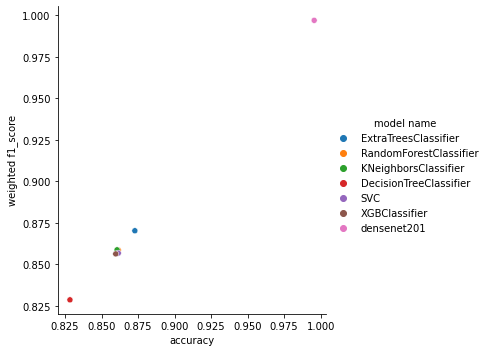

In [ ]:
sns.relplot(data=res,x='accuracy',hue='model name',y='weighted f1_score')

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
# X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=4)
pca.fit(X)

print(pca.explained_variance_ratio_)

print(pca.singular_values_)

[0.21257547 0.08863477 0.02291214 0.01744014]
[680.13684117 439.17921613 223.2916858  194.81155796]


In [ ]:
X_ = pca.fit_transform(X)

In [ ]:
len(X[0])

4

In [ ]:
LinearSVC, NuSVC

In [ ]:
clf = GaussianProcessClassifier()
clf.fit(g1,g3)

GaussianProcessClassifier()

In [ ]:
y_hat = clf.predict(g2)

In [ ]:
print(classification_report(g4,y_hat))

              precision    recall  f1-score   support

           0       0.75      0.72      0.74        98
           1       0.86      0.87      0.87       189

    accuracy                           0.82       287
   macro avg       0.80      0.80      0.80       287
weighted avg       0.82      0.82      0.82       287



In [ ]:
dir(sklearn.tree)
# classification_report

In [ ]:
from sklearn. model_selection import train_test_split

In [ ]:
g1,g2,g3,g4 = train_test_split(X_,Y)

In [ ]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)
# test_size = int(len(data)*.1)

In [ ]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
# test = data.skip(train_size+val_size).take(test_size)

In [ ]:
train_size

28

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense,Flatten,Dropout

from keras import backend as K

In [ ]:
resnet = DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

In [ ]:
K.clear_session()
model = Sequential()

In [ ]:
model.add(resnet)
# model.add(backbone)
model.add(Conv2D(16, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Conv2D(32, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
model.add(Conv2D(64, (3, 3), padding="valid", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding="same"))
# model.add(Conv2D(16, (3,3) ,1 ,activation='relu' ,input_shape=(256,256,3)))
# model.add(MaxPooling2D())
# model.add(Conv2D(32,(3,3),1,activation='relu'))
# model.add(MaxPooling2D())
# model.add(Conv2D(16,(3,3),1,activation='relu'))
# model.add(MaxPooling2D())
model.add(Flatten())
# model.add(Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.BatchNormalization())
# model.add(layers.Dense(2, activation='sigmoid'))
# model.add(Dense(1024,activation='relu'))
# model.add(Dense(512,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))



In [ ]:
model.compile('adam',loss=tf.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 conv2d (Conv2D)             (None, 6, 6, 16)          276496    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 6, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 32)          4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 64)          1

In [ ]:
logdir = 'logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train,epochs=12,validation_data=val,callbacks=[tensorboard_callback])

Epoch 1/12
28/28 [==============================] - 72s 2s/step - loss: 0.4879 - accuracy: 0.7790 - val_loss: 7.2610 - val_accuracy: 0.6607
Epoch 2/12
28/28 [==============================] - 42s 1s/step - loss: 0.4142 - accuracy: 0.8449 - val_loss: 5.4195 - val_accuracy: 0.6920
Epoch 3/12
28/28 [==============================] - 42s 1s/step - loss: 0.3268 - accuracy: 0.8850 - val_loss: 7.2137 - val_accuracy: 0.6875
Epoch 4/12
28/28 [==============================] - 42s 1s/step - loss: 0.2815 - accuracy: 0.8929 - val_loss: 2.6226 - val_accuracy: 0.6875
Epoch 5/12
28/28 [==============================] - 42s 1s/step - loss: 0.3350 - accuracy: 0.8594 - val_loss: 1.1268 - val_accuracy: 0.6071
Epoch 6/12
28/28 [==============================] - 42s 1s/step - loss: 0.2942 - accuracy: 0.8873 - val_loss: 4.4057 - val_accuracy: 0.7009
Epoch 7/12
28/28 [==============================] - 42s 1s/step - loss: 0.2191 - accuracy: 0.9152 - val_loss: 6.4348 - val_accuracy: 0.6384
Epoch 8/12
28/28 [==

In [ ]:
#evaluate model
model.evaluate(val)

7/7 [==============================] - 12s 180ms/step - loss: 2.1319 - accuracy: 0.7232


[2.131859064102173, 0.7232142686843872]